# Climate Change Analysis Belief 2022
© Explore Data Science Academy

_Prepared by:_
- Jessica Njuguna
- Stanley Agbo
- Uchenna Unigwe
- Hunadi Mawela
- Teddy Waweru

## Introduction

### Problem Statement

In the 21st Century, more companies build their brand with the consideration of **lessened environmental impact** or **carbon footprint**. Thus, their operations products and services are inclined to being more **environmentally friendly** and sustainable, in line with their values and ideals. <br>
To improve market research on their products/services, we developed the folowing **ML project** that intends to determine how people **perceive climate change**, and _whether or not they believe it is a real threat_. <br>

We believe this would provide a **metric** on how companies' products/service may be **received by the public**. Providing a robust ML solution will enable our clients to **access to a broad base of consumer sentiment**, spanning multiple demographic and geographic categories - thus **increasing their insights and informing future marketing strategies**.<br>

To build our **predictive model** for the project, we utilized a dataset of **collected tweet data** to determine if a person believes in climate data or _not_.


### Table of Contents

[Introduction](#introduction)
- Problem Statement
- Table of Contents
- Summary
    - Agenda
    - Deliverables
    - Results
    - Future Considerations
- Preliminary Activities
    - Importing Packages
    - Loading the Datasets
    
[Exploratory Data Analysis](#exploratory_data_analysis)
- Functions Declaration
- Statistical Summaries
    - Train Dataset
    - Test Dataset
- Visualizations

[Data Engineering](#data_engineering)
- Functions Declaration
- Dealing with Null Values
- Splitting features
- Dummy Variables
- Data Scaling
- Feature Selection

[Modelling](#modelling)
- Functions Declaration
- RandomForest Classification
    - Model Development
    - Model Performance Metrics
    - Test Dataset Prediction Metrics
- XG Boost Classification
    - Model Development
    - Model Performance Metrics
    - Test Dataset Prediction Metrics
- Hyper Parameter Tuning

[Model Performance Comparison](#model_performance_comparison)


[Model Explanation](#model_explanation)

[Conclusion](#conclusion)

[Appendix](#appendix)
- Kaggle Submission
    - Functions Declaration
    - Submission Metrics




    






### _Summary_

**Agenda:**

**Deliverables:**

**Results:**

**Future Considerations:**

### Preliminary Activities

#### Importing Packages

In [70]:
# Libraries for data loading, data manipulation
import pandas as pd
import numpy as np

#Libraries for Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 1)
from wordcloud import WordCloud
from statsmodels.graphics.correlation import plot_corr

#Libraries to clean the text
import contractions #This expands contraction such as 'don't' to 'do not'
import regex as re
import string
import nltk
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import emoji #allows us to manipulate with emojis

# Libraries for data preparation
# import statsmodels.formula.api as sm
# from statsmodels.formula.api import ols
# from scipy.stats import pearsonr
# from statsmodels.distributions.empirical_distribution import ECDF       #Imported for displaying the Empirical Cumulative Distribution of Features
# from sklearn.feature_selection import SelectKBest, f_regression

# Libraries for model building
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.tree import DecisionTreeRegressor

#Libraries for Model Performance
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.tree import plot_tree
# from sklearn.model_selection import GridSearchCV


#Libraries for mathematical analyses
# import numpy as np


#Library for creating pickle files of the models
# import pickle

# Setting global constants to ensure notebook results are reproducible
# PARAMETER_CONSTANT = ###

#### Loading the datasets

In [39]:
raw_train_df = pd.read_csv('resources/data/train.csv')
raw_test_df = pd.read_csv('resources/data/test.csv')

## Exploratory Data Analysis

### Functions Declaration

In [71]:
### We declare the functions that we can call later within the project development

#The function below takes a string and expands all contractions in the string
def expand_contractions(text):
    expanded = contractions.fix(text)
    return expanded

# Function to drop links from text using regex to replace the link with a comma
def strip_links(text):
    link_regex = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

# Function to drop mentions from text
def strip_mentions_punctuations(text):
    strip_sign = ['@']
    for separator in  string.punctuation:
        if separator not in strip_sign :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in strip_sign:
                words.append(word)
    return ' '.join(words)

#Function to Lemmatize the words
lemmatizer = WordNetLemmatizer()
def tweet_lemma(text, lemmatizer):
    return [lemmatizer.lemmatize(t) for t in text]    

#Function to remove stop_words
def remove_stop_words(text):    
    return [t for t in text if t not in stopwords.words('english')]

#Function to remove emojis
def remove_emojis(text):
    return [t for t in text if t not in emoji.UNICODE_EMOJI]

### Statistical Summaries

#A00 explanation on the type of summaries that we considered for the project

#### Train Dataset

In [50]:
train_df = raw_train_df.copy(deep = True)

In [51]:
train_df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


The train data set contains three columns containing the tweet, the sentiment and the tweetid

In [52]:
train_df.shape

(15819, 3)

The dataset contains 15,819 observations

In [53]:
train_df['sentiment'].value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

The sentiment column has four unique integers. They have the following meanings:
- 2 News: the tweet links to factual news about climate change
- 1 Pro: the tweet supports the belief of man-made climate change
- 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change
- -1 Anti: the tweet does not believe in man-made climate change

From the cell above, we see that Pro sentiments are the highest in the dataset with 8,530 observations. The Anti The sentiments are lowest with 1,296 obseravations. 

This shows that our data about the sentiments is imbalanced. Meaning we have more information about Pro sentiments than we do about Anti. Before modelling, we would have to balance the data sets using oversampling. This would optimize our prediction model.


In [54]:
len(train_df['tweetid'].unique())

15819

The unique values of the tweetid column are equal to the number of observations in the dataset. Therefore, they are unique identifies to the tweets and there are no duplicate values

In [55]:
len(train_df['message'].unique())

14229

There are 14,229 unique tweets. There are some duplicated tweets in the dataset.

In [56]:
train_df[train_df.duplicated(['message'])].shape

(1590, 3)

The duplicated tweets are 1,590

In [57]:
train_df.groupby('message').filter(lambda x: len(x['sentiment'].unique()) > 1)

,sentiment,message,tweetid
258,-1,RT @Uniocracy: They'll tell you theyre doing i...,529327
2390,2,RT @Channel4News: .@LeoDiCaprio calls on citiz...,460524
5393,0,RT @Uniocracy: They'll tell you theyre doing i...,723133
8446,0,RT @realDonaldTrump: Where the hell is global ...,228082
9141,0,RT @COP22: In 4 days the most ambitious climat...,407156
10351,1,RT @Channel4News: .@LeoDiCaprio calls on citiz...,93815
12001,-1,RT @realDonaldTrump: Where the hell is global ...,663534
14103,1,RT @COP22: In 4 days the most ambitious climat...,357058


Out of the duplicated observations, 8 of them are not equal in sentiment. These give us confilcting information about what text data constitutes to a particular sentiment and will be dropped in the feature engineering sector

In [58]:
train_df.isna().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

There are no null values in the dataset

In [59]:
for index,text in enumerate(train_df['message'][30:35]):
    print('Review %d:\n'%(index+1),text)

Review 1:
 @Jnp_Ftw are these the same scientists that denounce climate change? It's not a choice
Review 2:
 RT @Honey17011: A guide to global warming, Paris pact and the US role #DemForce #TheResistance #UniteBlue https://t.co/RYiBLwAJZ4
Review 3:
 RT @latimes: Atmospheric rivers fueled by climate change could decimate wild oysters in San Francisco Bay https://t.co/p0LZBhlU5K https://t…
Review 4:
 Denying climate change ignores basic science
Review 5:
 BGR ~ China practically says Trump lied about climate change https://t.co/Rz37HtcS8d


_Sampling the tweets, we see that some tweets contain url's, some mentions, beginning with @ and some hashtags. These would be cleaned to extract the parts of the tweet that direct us more toward the sentiment_

##### Preparing the text data

To further explore the data, we will clean the text by performing the following steps:

1. Expand contractions
2. Lower the message
3. Remove URL's
4. Remove mentions and punctuation
5. Remove digits and words containing digits


The cleaned tweets will be stored in a new column 'cleaned_message' to manage errors

_1. Expanding contractions_

In [60]:
train_df['cleaned_message']=train_df['message'].apply(lambda x:expand_contractions(x))
train_df['cleaned_message'][0:5]

0    PolySciMajor EPA chief does not think carbon d...
1    It is not like we lack evidence of anthropogen...
2    RT @RawStory: Researchers say we have three ye...
3    #TodayinMaker# WIRED : 2016 was a pivotal year...
4    RT @SoyNovioDeTodas: It is 2016, and a racist,...
Name: cleaned_message, dtype: object

_2. Lowercase all the tweets_

In [61]:
train_df['cleaned_message']=train_df['cleaned_message'].apply(lambda x: x.lower())
train_df['cleaned_message'][0:5]

0    polyscimajor epa chief does not think carbon d...
1    it is not like we lack evidence of anthropogen...
2    rt @rawstory: researchers say we have three ye...
3    #todayinmaker# wired : 2016 was a pivotal year...
4    rt @soynoviodetodas: it is 2016, and a racist,...
Name: cleaned_message, dtype: object

_3. Removing URLS_

In [62]:
train_df['cleaned_message']=train_df['cleaned_message'].apply(lambda x:strip_links(x))
train_df['cleaned_message'].head()

0    polyscimajor epa chief does not think carbon d...
1    it is not like we lack evidence of anthropogen...
2    rt @rawstory: researchers say we have three ye...
3    #todayinmaker# wired : 2016 was a pivotal year...
4    rt @soynoviodetodas: it is 2016, and a racist,...
Name: cleaned_message, dtype: object

_4. Remove mentions and punctuation_

In [63]:
train_df['cleaned_message']=train_df['cleaned_message'].apply(lambda x:strip_mentions_punctuations(x))
train_df['cleaned_message'].head()

0    polyscimajor epa chief does not think carbon d...
1    it is not like we lack evidence of anthropogen...
2    rt researchers say we have three years to act ...
3    todayinmaker wired 2016 was a pivotal year in ...
4    rt it is 2016 and a racist sexist climate chan...
Name: cleaned_message, dtype: object

In [64]:
train_df['cleaned_message']=train_df['cleaned_message'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

_5. Remove digits and words containing digits_

In [65]:
train_df['cleaned_message']=train_df['cleaned_message'].apply(lambda x: re.sub('\w*\d\w*','', x))
train_df['cleaned_message'].head()

0    polyscimajor epa chief does not think carbon d...
1    it is not like we lack evidence of anthropogen...
2    rt researchers say we have three years to act ...
3    todayinmaker wired  was a pivotal year in the ...
4    rt it is  and a racist sexist climate change d...
Name: cleaned_message, dtype: object

_6. Remove extra spaces_

In [66]:
train_df['cleaned_message'] = train_df['cleaned_message'].apply(lambda x: re.sub(' +',' ',x))

_7. Tokenizer_

In [67]:
tokeniser = TreebankWordTokenizer()
train_df['cleaned_message'] = train_df['cleaned_message'].apply(tokeniser.tokenize)
train_df['cleaned_message'].head()

0    [polyscimajor, epa, chief, does, not, think, c...
1    [it, is, not, like, we, lack, evidence, of, an...
2    [rt, researchers, say, we, have, three, years,...
3    [todayinmaker, wired, was, a, pivotal, year, i...
4    [rt, it, is, and, a, racist, sexist, climate, ...
Name: cleaned_message, dtype: object

_8. Lemmatize_

In [68]:
train_df['cleaned_message'] = train_df['cleaned_message'].apply(tweet_lemma, args=(lemmatizer, ))
train_df['cleaned_message'].head()

0    [polyscimajor, epa, chief, doe, not, think, ca...
1    [it, is, not, like, we, lack, evidence, of, an...
2    [rt, researcher, say, we, have, three, year, t...
3    [todayinmaker, wired, wa, a, pivotal, year, in...
4    [rt, it, is, and, a, racist, sexist, climate, ...
Name: cleaned_message, dtype: object

_9. Removing stopwords_

In [72]:
train_df['cleaned_message'] = train_df['cleaned_message'].apply(remove_stop_words)

In [73]:
train_df['cleaned_message'].head()

0    [polyscimajor, epa, chief, doe, think, carbon,...
1    [like, lack, evidence, anthropogenic, global, ...
2    [rt, researcher, say, three, year, act, climat...
3    [todayinmaker, wired, wa, pivotal, year, war, ...
4    [rt, racist, sexist, climate, change, denying,...
Name: cleaned_message, dtype: object

_10. Removing emojis_

In [74]:
train_df['cleaned_message'] = train_df['cleaned_message'].apply(remove_emojis)

#### Deeper EDA

Let's group the data by sentiment

In [75]:
train_grouped=train_df[['sentiment','cleaned_message']].groupby('sentiment').agg(sum)

In [76]:
train_grouped

,cleaned_message
sentiment,
-1,"[sally, kohn’s, latest, evidence, climate, cha..."
0,"[calum, tweet, abt, reunitingish, w, cast, see..."
1,"[polyscimajor, epa, chief, doe, think, carbon,..."
2,"[rt, researcher, say, three, year, act, climat..."


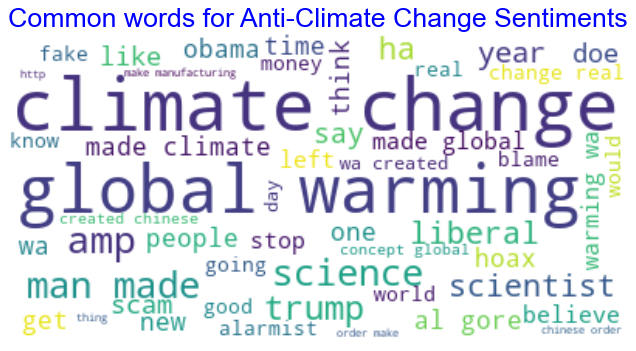

In [77]:
stopwords = set([])
stopwords.update(["rt", 'â', "u"])
text = train_grouped.iloc[0,0]
wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=50, background_color="white").generate_from_text(' '.join(text))
plt.figure(figsize=(10,6), dpi=80)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Common words for Anti-Climate Change Sentiments', fontsize = 24, color = 'blue')
plt.axis("off")
plt.show()

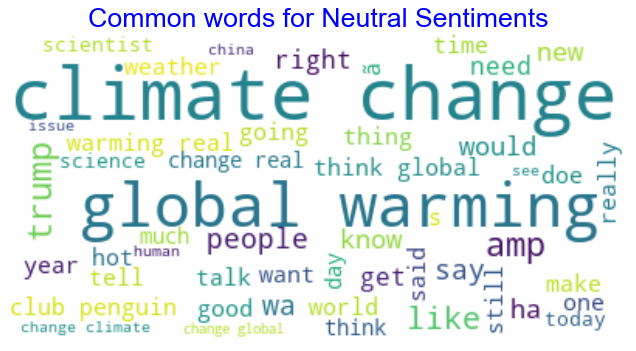

In [78]:
text = train_grouped.iloc[1,0]
wordcloud = WordCloud(stopwords=stopwords,max_font_size=50, max_words=50, background_color="white").generate_from_text(' '.join(text))

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,6), dpi=80)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Common words for Neutral Sentiments', fontsize = 24, color = 'blue')
plt.axis("off")
plt.show()

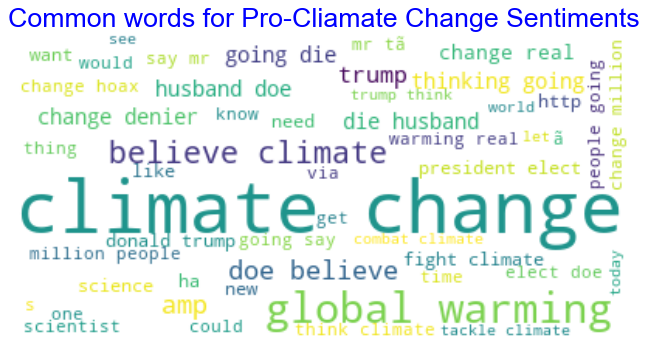

In [79]:
text = train_grouped.iloc[2,0]
wordcloud = WordCloud(stopwords=stopwords,max_font_size=50, max_words=50, background_color="white").generate_from_text(' '.join(text))

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,6), dpi=80)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Common words for Pro-Cliamate Change Sentiments', fontsize = 24, color = 'blue')
plt.axis("off")
plt.show()

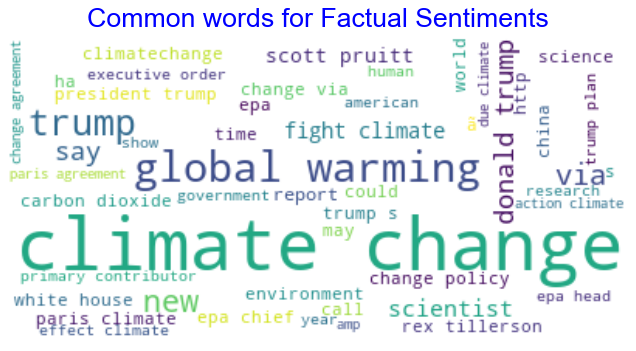

In [80]:
text = train_grouped.iloc[3,0]
wordcloud = WordCloud(stopwords=stopwords,max_font_size=50, max_words=50, background_color="white").generate_from_text(' '.join(text))


plt.figure(figsize=(10,6), dpi=80)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Common words for Factual Sentiments', fontsize = 24, color = 'blue')
plt.show()

#### Test Dataset

In [88]:
test_df = raw_test_df.copy(deep = True)

In [89]:
test_df.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \r\nPu...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [90]:
raw_test_df.shape

(10546, 2)

In [91]:
raw_test_df.isna().sum()

message    0
tweetid    0
dtype: int64

In [92]:
len(raw_test_df['tweetid'].unique())

10546

In [93]:
for index,text in enumerate(raw_test_df['message'][30:35]):
    print('Review %d:\n'%(index+1),text)

Review 1:
 How to green the world's deserts and reverse climate change | Allan Savory https://t.co/lYwtQN6ZlQ via @YouTube
Review 2:
 RT @94kristin: let's talk climate change
Review 3:
 RT @mymodernmet: Photographer @thevonwong raises awareness for victims of climate change with epic shoot on a bed of lavaÃ¢â‚¬Â¦
Review 4:
 RT @SteveSGoddard: No matter how much Democrats scream and lie and protest and spread their hatred, the global warming scam will always be…
Review 5:
 RT @TIME: An entire Canadian river vanished due to climate change, researchers say https://t.co/gS6h3j6c9g


### Visualizations

<AxesSubplot:>

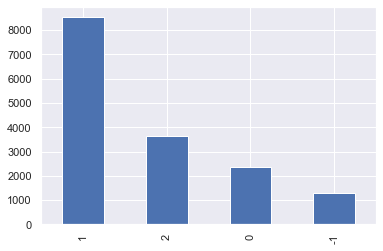

In [94]:
raw_train_df['sentiment'].value_counts().plot(kind = 'bar')

## Data Engineering

### Functions Declaration

### Dealing with Null Values

### Splitting Features

### Dummy Variables

### Data Scaling

### Feature Selection

## Modelling

### Functions Declaration

### RandomForest Classification

#### Model Development

#### Model Performance Metrics

#### Test Dataset Prediction Metrics

### XG Boost Classification

#### Model Development

#### Model Performance Metrics

#### Test Dataset Prediction Metrics

### Hyper Parameter Tuning

## Model Performance Comparison

### Functions Declaration

## Model Explanation

## Conclusion

## Appendix

### Kaggle Submission

#### Functions Declaration

#### Submission Metrics

In [87]:
###